<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Final Project : Predicting the price of steam games

_Author: Emmanuel Olagbaju_

---

### 1) Importing most of the libraries I will need and loading in my data set

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

end_date='31/05/2019'

steam_df = pd.read_csv('Steam sales data.csv')
#checking for any nulls/nas
steam_df[steam_df.isnull().any(axis=1)]

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price


### 2) Pre processing the data through various functions

In [3]:
#converting the release dates into months since release to make it easier for the model to interpret it as a feature
def str_pre_proc(strdate):
    return(int(strdate[-4:]),int(strdate[3:5]),int(strdate[0:2]))

def months_released(entry_date):
    mod_date=str_pre_proc(entry_date)
    end_date = datetime.datetime(2019,5,31)
    start_date= datetime.datetime(mod_date[0],mod_date[1],mod_date[2])
    return ((end_date.year - start_date.year) * 12 + (end_date.month - start_date.month))

months_released('01/01/2012')

steam_df['months_out']=steam_df['release_date'].apply(months_released)

In [4]:
import re
def publisher_conversion(pub):
    if ((steam_df['publisher']==pub).sum())>49:
        return 1
    elif re.search(".*2K,*",pub):
        return 1
    elif re.search(".*ctivision,*",pub):
        return 1
    elif re.search(".*ockstar,*",pub):
        return 1
    elif re.search(".*Epic Games,*",pub):
        return 1
    elif re.search(".*Valve,*",pub):
        return 1
    elif re.search(".*onami,*",pub):
        return 1
    else: return 0
#using a function to convert the publisher column into 1 for bigger publishers and 0 for smaller ones
steam_df['pub_binary']=steam_df['publisher'].apply(publisher_conversion)

In [5]:
def multiplayer(cat):
    if re.search(".*ulti-player.*",cat):
        return 1
    else: return 0
# adding a column for whether a game is multiplayer or not
steam_df['multiplayer']=steam_df['categories'].apply(multiplayer)

In [6]:
steam_df['owners'].value_counts()
owner_map={'0-20000':1,
          '20000-50000':2,
          '50000-100000':3,
          '100000-200000':4,
          '200000-500000':5,
          '500000-1000000':6,
          '1000000-2000000':7,
          '2000000-5000000':8,
          '5000000-10000000':9,
          '10000000-20000000':10,
          '20000000-50000000':11,
          '50000000-100000000':12,
          '100000000-200000000':13}
#converting the owners ranges into numbers to make it easier for a model to interpret
#glass['household'] = glass.glass_type.map({1:0, 2:0, 3:0, 5:1, 6:1, 7:1}) check if map is faster
steam_df['owner_scale']=steam_df['owners'].replace(owner_map)

In [7]:
#adding a column that shows the ratio of positive to negative ratings
steam_df['rating_ratio']=round(steam_df['positive_ratings']/steam_df['negative_ratings'],2)
steam_df['rating_ratio']=np.where((steam_df['negative_ratings']==0) & (steam_df['positive_ratings']<=5),3,steam_df['rating_ratio'])
steam_df['rating_ratio']=np.where((steam_df['negative_ratings']==0) & (steam_df['positive_ratings']<50) & (steam_df['positive_ratings']>5),15,steam_df['rating_ratio'])
steam_df['rating_ratio']=np.where((steam_df['negative_ratings']==0) & (steam_df['positive_ratings']>=50),30,steam_df['rating_ratio'])
steam_df['rating_ratio']=np.where((steam_df['positive_ratings']==0) & (steam_df['negative_ratings']>=1),-1,steam_df['rating_ratio'])

In [8]:
#converting the prices into either a 1 or 0, 1 if less than £5, 0 if greater than
steam_df['binary_price']=np.where(steam_df['price']>5,0,1)


### 3) Building and testing the actual models

#### 3i) Logistic Regression

Confusion Matrix:
 [[ 571 2829]
 [ 338 4385]] 
Accuracy: 61.01 % 
Precision: 60.78 % 
Recall: 92.84 % 
F1: 73.47 %


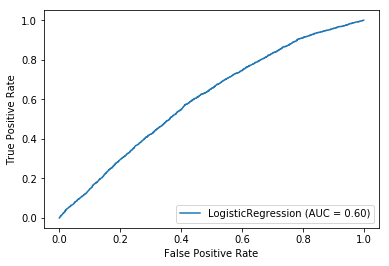

In [9]:
#Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve, confusion_matrix, accuracy_score, precision_score, recall_score,f1_score
logreg = LogisticRegression(solver="lbfgs")

feat_cols=['median_playtime','months_out','owner_scale','rating_ratio','pub_binary']

X=steam_df[feat_cols]
y=steam_df['binary_price']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42,test_size=0.3)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)


print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred),
      "\nAccuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%",
      "\nPrecision:", round(precision_score(y_test, y_pred) * 100, 2), "%",
      "\nRecall:", round(recall_score(y_test, y_pred) * 100, 2), "%",      
      "\nF1:", round(f1_score(y_test, y_pred) * 100, 2), "%")
plot_roc_curve(logreg, X_test, y_test);

#### 3ii) Decision trees

In [10]:
#Decision Trees
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score,f1_score
# treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
# treeclf.fit(X, y)

treeclf = DecisionTreeClassifier(max_depth=5, random_state=1)
#,'average_playtime','achievements','positive_ratings', 'negative_ratings','owner_scale','median_playtime' ,'rating_ratio'
feat_cols=['median_playtime','months_out','achievements','pub_binary','positive_ratings']
#feat_cols=['median_playtime','months_out','achievements','rating_ratio','owner_scale']
#1 achievements, 2 median playtime
X=steam_df[feat_cols]
y=steam_df['binary_price']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42,test_size=0.33)

treeclf.fit(X_train,y_train)
y_pred=treeclf.predict(X_test)
print(treeclf.score(X_test,y_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred),
      "\nAccuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%",
      "\nPrecision:", round(precision_score(y_test, y_pred) * 100, 2), "%",
      "\nRecall:", round(recall_score(y_test, y_pred) * 100, 2), "%",      
      "\nF1:", round(f1_score(y_test, y_pred) * 100, 2), "%")

pd.DataFrame({'feature':feat_cols, 'importance':treeclf.feature_importances_})

0.6560716284275322
Confusion Matrix:
 [[1295 2422]
 [ 651 4567]] 
Accuracy: 65.61 % 
Precision: 65.35 % 
Recall: 87.52 % 
F1: 74.83 %


,feature,importance
0,median_playtime,0.153354
1,months_out,0.072960
2,achievements,0.296138
3,pub_binary,0.049671
4,positive_ratings,0.427877


#### 3iii) Gradient Boosting Classifier - best iteration seemed to be 150 estimators and a max depth of 5

In [11]:
#Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score,f1_score

# ['appid', 'name', 'release_date', 'english', 'developer', 'publisher',
#        'platforms', 'required_age', 'categories', 'genres', 'steamspy_tags',
#        'achievements', 'positive_ratings', 'negative_ratings',
#        'average_playtime', 'median_playtime', 'owners', 'price', 'multiplayer',
#        'owner_scale', 'binary_price']


feat_cols=['median_playtime','months_out','achievements','positive_ratings', 'required_age','negative_ratings',
             'average_playtime','owner_scale', 'multiplayer','pub_binary' ]
X=steam_df[feat_cols]
y=steam_df['binary_price']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42,test_size=0.3)

gbc = GradientBoostingClassifier(n_estimators=150, max_depth=5)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred),
      "\nAccuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%",
      "\nPrecision:", round(precision_score(y_test, y_pred) * 100, 2), "%",
      "\nRecall:", round(recall_score(y_test, y_pred) * 100, 2), "%",      
      "\nF1:", round(f1_score(y_test, y_pred) * 100, 2), "%")

Confusion Matrix:
 [[1680 1720]
 [ 705 4018]] 
Accuracy: 70.15 % 
Precision: 70.02 % 
Recall: 85.07 % 
F1: 76.82 %


#### 3iv) Iterating through several variations and plotting to get the best parameters for the Gradient Boosting Classifier

In [12]:
#Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score,f1_score

# ['appid', 'name', 'release_date', 'english', 'developer', 'publisher',
#        'platforms', 'required_age', 'categories', 'genres', 'steamspy_tags',
#        'achievements', 'positive_ratings', 'negative_ratings',
#        'average_playtime', 'median_playtime', 'owners', 'price', 'multiplayer',
#        'owner_scale', 'binary_price']


feat_cols=['median_playtime','months_out','achievements','positive_ratings', 'required_age','negative_ratings',
             'average_playtime','owner_scale', 'multiplayer','pub_binary', 'rating_ratio']
X=steam_df[feat_cols]
y=steam_df['binary_price']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42,test_size=0.3)

optimize_check=[['N_estimators','Max_depth','Accuracy','Precision','Recall','F1']]

for n_est in range(50,550,50):
    for depth in range(3,9):
        gbc = GradientBoostingClassifier(n_estimators=n_est, max_depth=depth)
        gbc.fit(X_train, y_train)
        y_pred = gbc.predict(X_test)
        optimize_check.append([n_est,depth,round(accuracy_score(y_test, y_pred) * 100, 2),
               round(precision_score(y_test, y_pred) * 100, 2),round(recall_score(y_test, y_pred) * 100, 2)
                , round(f1_score(y_test, y_pred) * 100, 2)   ])

opt_df=pd.DataFrame(optimize_check)
opt_df

,0,1,2,3,4,5
0,N_estimators,Max_depth,Accuracy,Precision,Recall,F1
1,50,3,68.87,68.14,87.25,76.52
2,50,4,69.86,69.33,86.39,76.92
3,50,5,69.97,69.68,85.6,76.83
4,50,6,69.86,69.64,85.39,76.72
5,50,7,70.2,70.02,85.22,76.88
6,50,8,69.72,69.88,84.23,76.38
7,100,3,69.94,69.39,86.43,76.98
8,100,4,70.24,69.87,85.86,77.04
9,100,5,70.18,69.99,85.28,76.88


### 4) Feature Importance

Text(0.5,1,'Feature Importance (steam)')

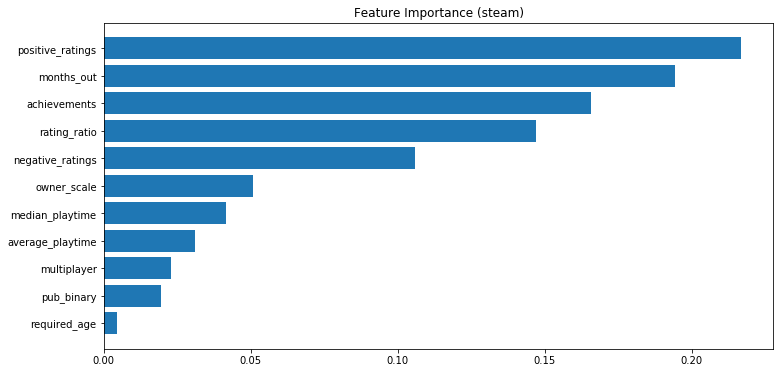

In [13]:
gbc.feature_importances_

# feature_importance = reg.feature_importances_
# sorted_idx = np.argsort(feature_importance)
# pos = np.arange(sorted_idx.shape[0]) + .5
# fig = plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.barh(pos, feature_importance[sorted_idx], align='center')
# plt.yticks(pos, np.array(diabetes.feature_names)[sorted_idx])
# plt.title('Feature Importance (MDI)')

feature_importance = gbc.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title('Feature Importance (steam)')

In [14]:
steam_df[['positive_ratings']].describe()    

,positive_ratings
count,2.707500e+04
mean,1.000559e+03
std,1.898872e+04
min,0.000000e+00
25%,6.000000e+00
50%,2.400000e+01
75%,1.260000e+02
max,2.644404e+06


In [15]:
#24 is the median positive ratings
steam_df['pub_binary'][steam_df['positive_ratings']>=24].value_counts()

0    12156
1     1593
Name: pub_binary, dtype: int64

In [16]:
steam_df[['achievements']].describe()  

,achievements
count,27075.000000
mean,45.248864
std,352.670281
min,0.000000
25%,0.000000
50%,7.000000
75%,23.000000
max,9821.000000


In [17]:
steam_df['pub_binary'][steam_df['achievements']>=7].value_counts()

0    12616
1     1153
Name: pub_binary, dtype: int64

In [18]:
steam_df[['months_out']].describe()  

,months_out
count,27075.000000
mean,28.467368
std,25.572283
min,0.000000
25%,11.000000
50%,21.000000
75%,37.000000
max,263.000000


In [19]:
steam_df['pub_binary'][steam_df['months_out']>=21].value_counts()

0    12290
1     1743
Name: pub_binary, dtype: int64